## DEMANDA DE BICICLETAS COMPARTIDAS

In [1]:
# Importación de librerias

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor


In [2]:
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [3]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB


In [5]:
df['year']= pd.DatetimeIndex(df['dteday']).year
df['month']= pd.DatetimeIndex(df['dteday']).month
df['day']= pd.DatetimeIndex(df['dteday']).day
df['dayofweek']= pd.DatetimeIndex(df['dteday']).dayofweek

In [6]:
#Identificamos las columnas que tienen valores nulos
df.isnull().sum()

instant         0
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
year            0
month           0
day             0
dayofweek       0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
mapeo = {'Clear, Few clouds, Partly cloudy, Partly cloudy':'1', 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist'
           :'2', 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds':'3',
           'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog':'4'}
df['weathersit'] = df['weathersit'].replace(mapeo)
df['weathersit'] = df['weathersit'].astype('int')
assert df['weathersit'].dtype == 'int'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     16883 non-null  int64         
 1   dteday      16883 non-null  datetime64[ns]
 2   hr          16883 non-null  int64         
 3   weathersit  16883 non-null  int32         
 4   temp        16883 non-null  float64       
 5   atemp       16883 non-null  float64       
 6   hum         16883 non-null  float64       
 7   windspeed   16883 non-null  float64       
 8   casual      16883 non-null  int64         
 9   registered  16883 non-null  int64         
 10  cnt         16883 non-null  int64         
 11  year        16883 non-null  int64         
 12  month       16883 non-null  int64         
 13  day         16883 non-null  int64         
 14  dayofweek   16883 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(9)
memory usage: 2.0

In [9]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,dayofweek
0,1,2011-01-01,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,1,1,5
1,2,2011-01-01,1,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,1,5
2,3,2011-01-01,2,1,0.22,0.2727,0.80,0.0,5,27,32,2011,1,1,5
3,4,2011-01-01,3,1,0.24,0.2879,0.75,0.0,3,10,13,2011,1,1,5
4,5,2011-01-01,4,1,0.24,0.2879,0.75,0.0,0,1,1,2011,1,1,5


In [10]:
df = df.drop("dteday", axis=1)
df.head()

,instant,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,dayofweek
0,1,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,1,1,5
1,2,1,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,1,5
2,3,2,1,0.22,0.2727,0.80,0.0,5,27,32,2011,1,1,5
3,4,3,1,0.24,0.2879,0.75,0.0,3,10,13,2011,1,1,5
4,5,4,1,0.24,0.2879,0.75,0.0,0,1,1,2011,1,1,5


In [11]:
categorical_variables = ["hr", "weathersit", "dayofweek", "year", "month", "day", "dayofweek", "hour"]
continuous_variables = ["temp", "atemp", "hum", "windspeed", "casual", "registered", "count"]

print(f'There are {len(categorical_variables)} categorical variables.')
print(f'There are {len(continuous_variables)} continuous variables.')

There are 8 categorical variables.
There are 7 continuous variables.


In [12]:
df['cnt'].describe()

count    16883.000000
mean       188.830717
std        181.035062
min          1.000000
25%         40.000000
50%        141.000000
75%        280.000000
max        977.000000
Name: cnt, dtype: float64

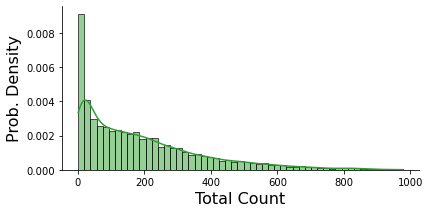

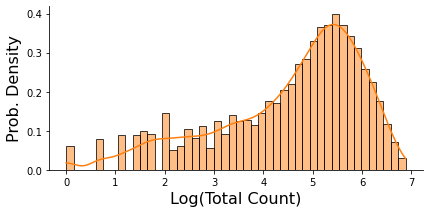

In [13]:
sns.displot(df["cnt"], kde=True, height=3, aspect=2, stat='density', color='tab:green')
plt.xlabel('Total Count', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)

sns.displot(np.log(df["cnt"]), kde=True, height=3, aspect=2, stat='density', color='tab:orange')
plt.xlabel('Log(Total Count)', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)
plt.show()

**Q-Q Gráficos para el uso total de la bicicleta y la transformación logarítmica:**

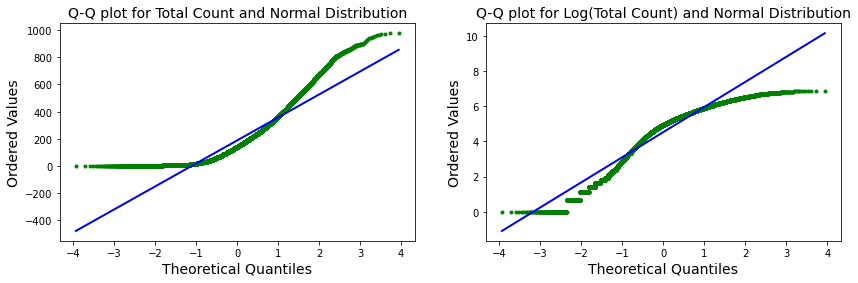

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
scipy.stats.probplot(df["cnt"], dist="norm", fit=True, plot=ax[0])
scipy.stats.probplot(np.log(df["cnt"]), dist="norm", fit=True, plot=ax[1])
ax[0].set_title('Q-Q plot for Total Count and Normal Distribution', fontsize=14)
ax[0].set_xlabel('Theoretical Quantiles', fontsize=14)
ax[0].set_ylabel('Ordered Values', fontsize=14)
ax[0].get_lines()[0].set_marker('.')
ax[0].get_lines()[0].set_markerfacecolor('g')
ax[0].get_lines()[0].set_markeredgecolor('g')
ax[0].get_lines()[1].set_linewidth(2.0)
ax[0].get_lines()[1].set_color('b')

ax[1].set_title('Q-Q plot for Log(Total Count) and Normal Distribution', fontsize=14)
ax[1].set_xlabel('Theoretical Quantiles', fontsize=14)
ax[1].set_ylabel('Ordered Values', fontsize=14)
ax[1].get_lines()[0].set_marker('.')
ax[1].get_lines()[0].set_markerfacecolor('g')
ax[1].get_lines()[0].set_markeredgecolor('g')
ax[1].get_lines()[1].set_linewidth(2.0)
ax[1].get_lines()[1].set_color('b')

plt.show()

**Distribución del uso de la bicicleta con temporada, clima, mes y día laborable:**

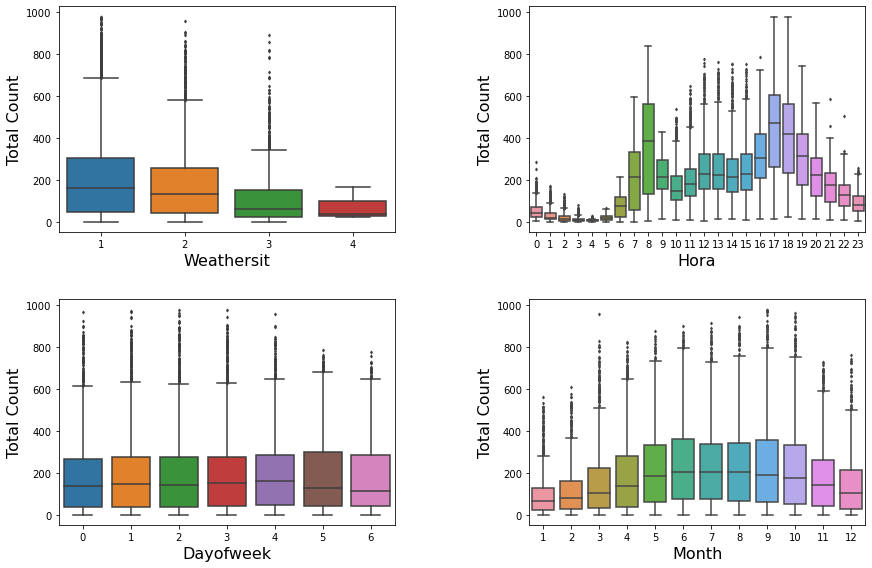

In [15]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14,9)
sns.boxplot(data=df, y="cnt", x="weathersit", ax=axs[0][0], fliersize=2)
sns.boxplot(data=df, y="cnt", x="hr", ax=axs[0][1], fliersize=2)
sns.boxplot(data=df, y="cnt", x="dayofweek", ax=axs[1][0], fliersize=2)
sns.boxplot(data=df, y="cnt", x="month", ax=axs[1][1], fliersize=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
axs[0][0].set_xlabel('Weathersit', fontsize=16)
axs[0][0].set_ylabel('Total Count', fontsize=16)
axs[0][1].set_xlabel('Hora', fontsize=16)
axs[0][1].set_ylabel('Total Count', fontsize=16)
axs[1][0].set_xlabel('Dayofweek', fontsize=16)
axs[1][0].set_ylabel('Total Count', fontsize=16)
axs[1][1].set_xlabel('Month', fontsize=16)
axs[1][1].set_ylabel('Total Count', fontsize=16)
plt.show()

**Correlacion:**

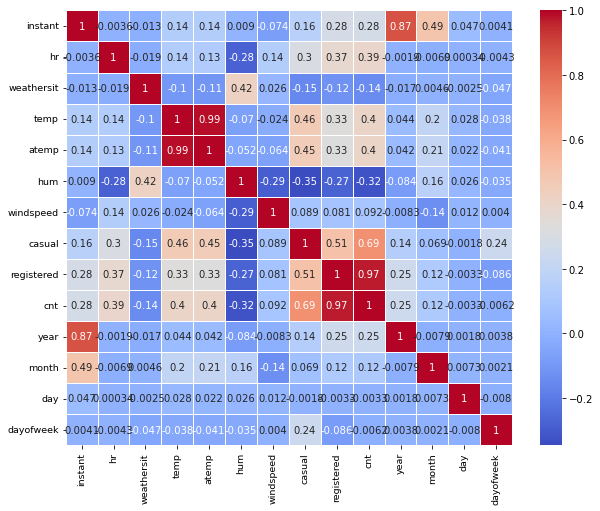

In [16]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

In [17]:
df.groupby(["year"]).mean()["cnt"]

year
2011    143.056350
2012    234.092826
Name: cnt, dtype: float64

**Uso medio de la bicicleta por día de la semana y hora:**

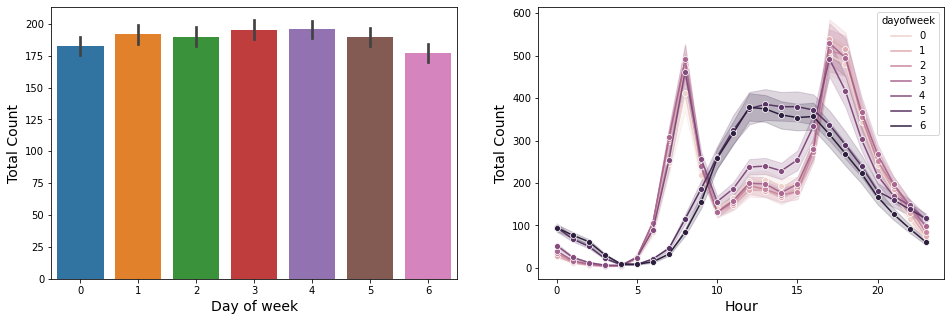

In [18]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,5)
sns.barplot(data=df, x="dayofweek", y="cnt", ax=axs[0])
sns.lineplot(data=df, x="hr", y="cnt", hue='dayofweek', marker='o', markers=True, dashes=False, ax=axs[1])
axs[0].set_xlabel("Day of week", fontsize=14)
axs[0].set_ylabel("Total Count", fontsize=14)
axs[1].set_xlabel("Hour", fontsize=14)
axs[1].set_ylabel("Total Count", fontsize=14)
plt.show()

In [19]:
df = df.drop(["casual", "registered", "atemp", "day"], axis=1)
df.head()

,instant,hr,weathersit,temp,hum,windspeed,cnt,year,month,dayofweek
0,1,0,1,0.24,0.81,0.0,16,2011,1,5
1,2,1,1,0.22,0.80,0.0,40,2011,1,5
2,3,2,1,0.22,0.80,0.0,32,2011,1,5
3,4,3,1,0.24,0.75,0.0,13,2011,1,5
4,5,4,1,0.24,0.75,0.0,1,2011,1,5


In [20]:
y = np.log1p(df['cnt'])  
X = df.drop('cnt', axis=1)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [22]:
scl = StandardScaler()
scl.fit(X_train) 

X_train_scaled = scl.transform(X_train)
X_valid_scaled = scl.transform(X_valid)

In [23]:
def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('R2 score:', r2_score(y_test, y_pred))
    print("root mean_squared_error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("mean_absolute_error: ", mean_absolute_error(y_test, y_pred))
    return y_pred

### Modelos de entrenamiento y ajuste de hiperparámetros con GridSearchCV:

### 1. Linear regression:

In [24]:
lr = LinearRegression()
lr_model = lr.fit(X_train_scaled, y_train)

print("Validation Set performance: ")
y_valid_pred_lr = predict(lr_model, X_valid_scaled, y_valid)

print('\n')

print("Training Set performance: ")
y_train_pred_lr = predict(lr_model, X_train_scaled, y_train)

Validation Set performance: 
R2 score: 0.46962001882114224
root mean_squared_error:  1.0268318003738266
mean_absolute_error:  0.8112485176408424


Training Set performance: 
R2 score: 0.48347211824988134
root mean_squared_error:  1.021985454781538
mean_absolute_error:  0.8093971602890258


### 2. Lasso regression:

In [25]:
lasso = LassoCV(n_alphas=100, cv=5)
lasso.fit(X_train_scaled, y_train)

print("LassoCV: Best hyperparameter alpha: ")
print(lasso.alpha_)

print('\n')

print("LassoCV: Best score: ")
print(lasso.score(X_train_scaled, y_train))

print('\n')

print("Validation set performance: ")
y_valid_pred_lasso = predict(lasso, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_lasso = predict(lasso, X_train_scaled, y_train)

LassoCV: Best hyperparameter alpha: 
0.0008619113308933235


LassoCV: Best score: 
0.48337609177673335


Validation set performance: 
R2 score: 0.4695494238289618
root mean_squared_error:  1.0269001351277058
mean_absolute_error:  0.8114278282620088


Training set performance: 
R2 score: 0.48337609177673335
root mean_squared_error:  1.0220804478124927
mean_absolute_error:  0.8093784048633782


### 3. K-Nearest-Neighbors (KNN) Regression:

In [26]:
knn = GridSearchCV(KNeighborsRegressor(), param_grid={"n_neighbors":list(range(1, 41))}, cv=10, scoring="neg_mean_squared_error")
knn.fit(X_train_scaled, y_train)

print("KNN best k-value: ")
print(knn.best_params_)

print('\n')

print("KNN best score: ")
print(knn.best_score_)

print('\n')

print("Validation set performance: ")
y_valid_pred_knn = predict(knn, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_knn = predict(knn, X_train_scaled, y_train)


KNN best k-value: 
{'n_neighbors': 5}


KNN best score: 
-0.5800316864253525


Validation set performance: 
R2 score: 0.7059105282134468
root mean_squared_error:  0.7646197065985724
mean_absolute_error:  0.5472485497736361


Training set performance: 
R2 score: 0.820790637357687
root mean_squared_error:  0.6019746152044991
mean_absolute_error:  0.42882416232232184


### Comparación de modelos e importancia de las características:

In [27]:
model_labels = ["Linear Regression", "Lasso", "KNN"]
model_y_valid_pred = [y_valid_pred_lr, y_valid_pred_lasso, y_valid_pred_knn] 
model_y_train_pred = [y_train_pred_lr, y_train_pred_lasso, y_train_pred_knn] 

r2_scores = [r2_score(y_valid, y_prediction) for y_prediction in model_y_valid_pred]
rmse_scores = [np.sqrt(mean_squared_error(y_valid, y_prediction)) for y_prediction in model_y_valid_pred]
mae_scores = [mean_absolute_error(y_valid, y_prediction) for y_prediction in model_y_valid_pred]

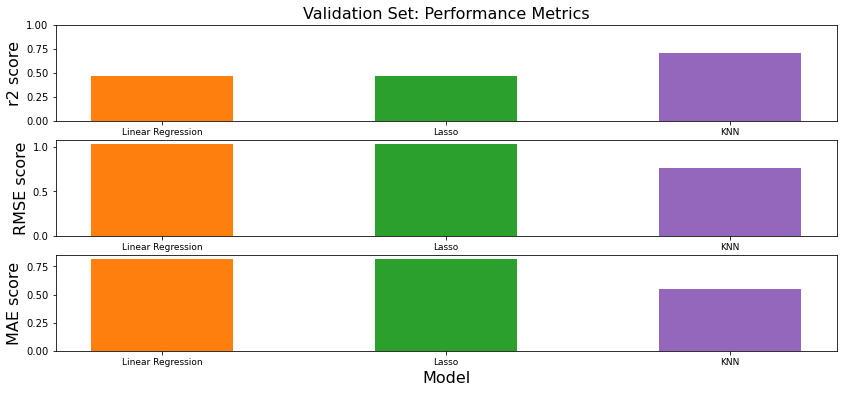

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(14,6))
colors = ['tab:orange', 'tab:green', 'tab:purple']

axs[0].set_title("Validation Set: Performance Metrics", fontsize=16)

axs[0].bar(range(0, len(model_labels)), r2_scores, width=0.5, color=colors)
axs[1].bar(x=range(len(model_labels)), height=rmse_scores, width=0.5, color=colors)
axs[2].bar(x=range(len(model_labels)), height=mae_scores, width=0.5, color=colors)

for i in range(3):
    axs[i].set_xticks(range(len(model_labels)))
    axs[i].set_xticklabels(labels=model_labels, fontsize=9, rotation=0)
    axs[i].set_xlabel("Model", fontsize=16)

axs[0].set_ylabel("r2 score", fontsize=16)
axs[1].set_ylabel("RMSE score", fontsize=16)
axs[2].set_ylabel("MAE score", fontsize=16)

axs[0].set_ylim([0,1])

plt.show()